In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import copy

In [2]:

# Import functions directly from github
# Important: note that we use raw.githubusercontent.com, not github.com

import requests
url = 'https://raw.githubusercontent.com/florisvb/Nonlinear_and_Data_Driven_Estimation/main/Utility/plot_utility.py'
r = requests.get(url)

# Store the file to the colab working directory
with open('plot_utility.py', 'w') as f:
    f.write(r.text)
f.close()

# import the function we want from that file
from plot_utility import plot_tme

# Constants

In [14]:
# System Parameters
m = 0.5 # mass
l = 0.2 # distance from rotor to COM
I = 2/5*m*l**2 # Moment of inertia (Iyy) -- assuming drone is a sphere (it is not)
g = 9.81 # gravity constant

# Control Parameters
tau_k_theta = 10 # torque control to stabilize theta
tau_k_thetadot = 20 # torque control to provide thetadot damping
tau_k_x = 0.01 # torque control to control x position
tau_k_xdot = 0.2 # torque control to provide xdot damping
F_k_z = 1000 # Force control to control z position
F_k_zdot = 10000 # Force control to control z position

F0 = m*g

# Noise for measurements: (standard deviations)
#v = [0.01, 0.001, 0.2, 0.2]
v = [0.01, 0.001, 0.2, 0.2, 0.000005, 0.000005]

# Desired trajectory

In [15]:
def desired_trajectory(t):
    theta_des = 0*np.ones_like(t)
    z_des = 1*np.ones_like(t)
    x_des = np.sin(0.01*t)
    return theta_des, x_des, z_des

# Nonlinear continuous time dynamics with control

In [16]:
def control(X, t):
    theta, thetadot, x, xdot, z, zdot = np.ravel(X)

    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)

    # error
    x_err = x_des - x
    z_err = z_des - z

    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot)

    return F, tau

In [17]:
def f(X, t):
    theta, thetadot, x, xdot, z, zdot = X

    # control
    F, tau = control(X, t)

    # dynamics
    d_theta = thetadot
    d_thetadot = tau/I
    d_x = xdot
    d_xdot = -F*np.sin(theta)/m
    d_z = zdot
    d_zdot = (F*np.cos(theta)-m*g)/m

    d_x = [d_theta, d_thetadot, d_x, d_xdot, d_z, d_zdot]

    return d_x

# Run simulation

In [18]:
t = np.arange(0, 5000, 0.1)

x0 = [(np.random.random()-0.5)*1e-3 for i in range(6)]

result = odeint(f, x0, t)
X = result.T

# Plot results

In [19]:
theta = X[0, :]
x = X[2, :]
z = X[4, :]

theta_des, x_des, z_des = desired_trajectory(t)

<Axes: xlabel='Time', ylabel='z'>

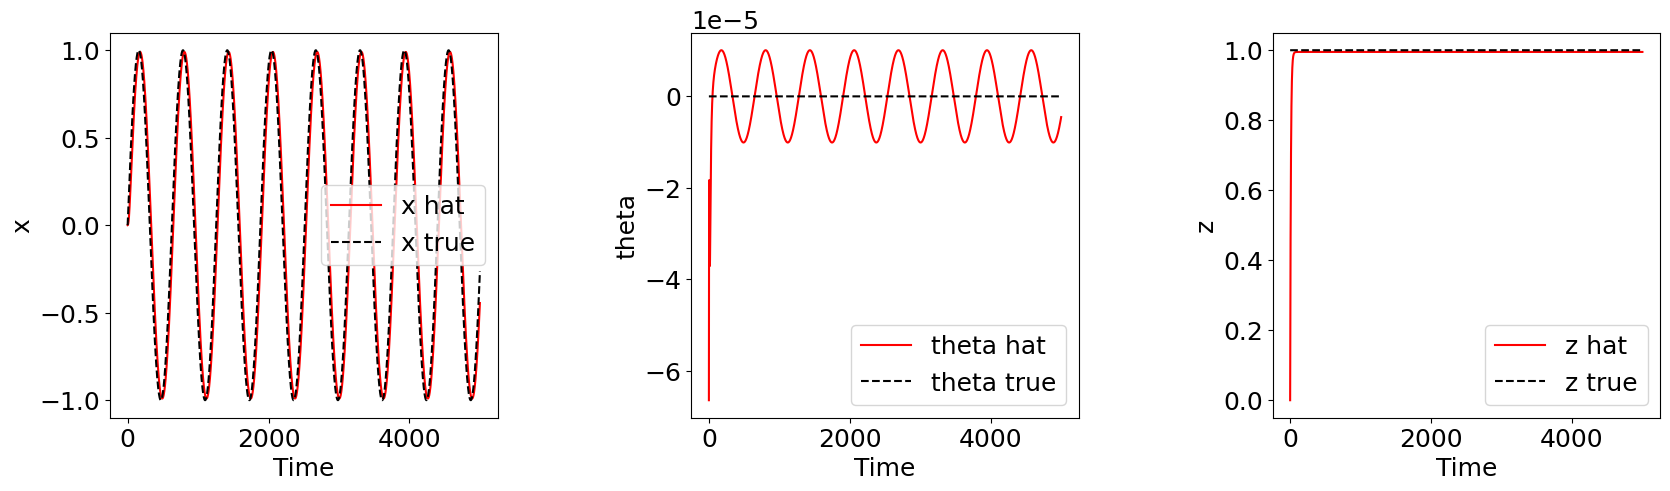

In [20]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x_des, None, x, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta_des, None, theta, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z_des, None, z, label_var='z', ax=ax3)

# Measurements

In [21]:
def h(X, v, t):
    theta, thetadot, x, xdot, z, zdot = X
    F, tau = control(X, t)

    xddot_direct = -F*np.sin(theta)/m
    zddot_direct = (F*np.cos(theta)-m*g)/m

    y = np.array([theta, thetadot, x, z, xddot_direct, zddot_direct])
    noise = np.array( [np.random.normal(0, vi) for vi in v] )

    return (y + noise).tolist()

In [22]:
Y = np.vstack( [h(X[:,i], v, t[i]) for i in range(X.shape[1]) ] ).T

<Axes: xlabel='Time', ylabel='z'>

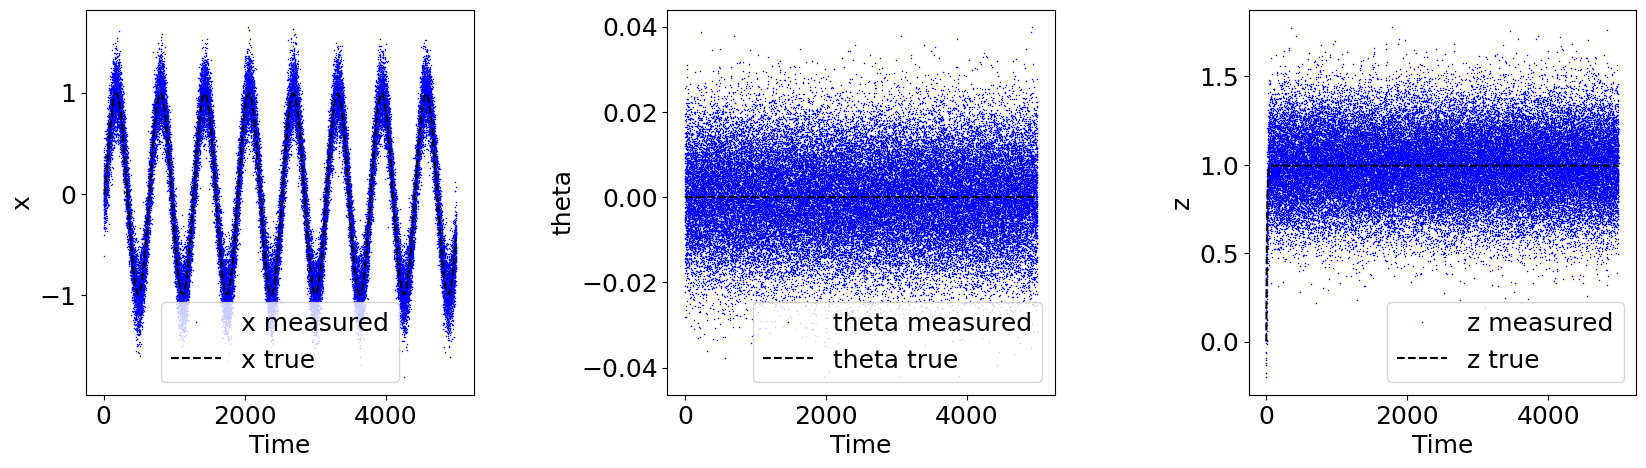

In [23]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x, Y[2,:], None, label_var='x', ax=ax1)

ax2 = fig.add_subplot(132)
plot_tme(t, theta, Y[0,:], None, label_var='theta', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z, Y[3,:], None, label_var='z', ax=ax3)

(-0.0002, 0.0002)

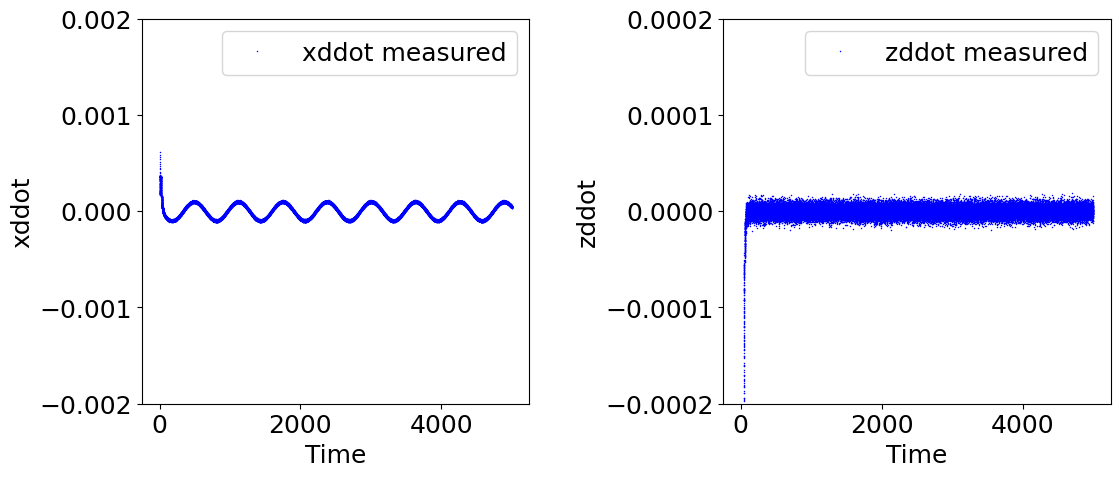

In [24]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, None, Y[4,:], None, label_var='xddot', ax=ax1)
plt.ylim(-0.002, 0.002)

ax2 = fig.add_subplot(132)
plot_tme(t, None, Y[5,:], None, label_var='zddot', ax=ax2)
plt.ylim(-0.0002, 0.0002)

# Discrete Linearized

In [25]:
def control_linear(X, t):
    theta, thetadot, x, xdot, z, zdot = X

    # desired trajectory
    theta_des, x_des, z_des = desired_trajectory(t)

    # error
    x_err = x_des - x
    z_err = z_des - z

    # control
    tau = -(tau_k_x*x_err - tau_k_xdot*xdot)  + (tau_k_theta*(-theta) - tau_k_thetadot*thetadot)
    F = (F_k_z*z_err - F_k_zdot*zdot) - F0

    return F, tau

In [26]:
dt = np.mean(np.diff(t))

A = np.array([[1,        dt, 0, 0,  0, 0],
              [0,        1,  0, 0,  0, 0],
              [0,        0,  1, dt, 0, 0],
              [-F0/m*dt, 0,  0, 1,  0, 0],
              [0,        0,  0, 0,  1, dt],
              [0,        0,  0, 0,  0, 1]])

B = np.array([[0,      0],
              [0,      1/I*dt],
              [0,      0],
              [0,      0],
              [0,      0],
              [1/m*dt, 0]])

C = np.array([[1, 0, 0, 0, 0, 0],
              [0, 1, 0, 0, 0, 0],
              [0, 0, 1, 0, 0, 0],
              [0, 0, 0, 0, 1, 0],
              [-F0/m, 0, 0, 0, 0, 0], # xddot measurement
              [0, 0, 0, 0, 0, 0]])   #

# xddot_direct = -F*np.sin(theta)/m
# zddot_direct = (F*np.cos(theta)-m*g)/m

D = np.zeros([6, 2])
D[5,0] = 1/m

# Organize some inputs for the KF

In [27]:
# get the control inputs -- these should be known
u = control_linear(X, t)
u = np.vstack(u)

# R is determined by the variance, thus the square of the standard deviation
R = np.diag(v)**2

# Q defines how trustworthy the model is. More trusted models result in smoother estimates.
# But they can be led astray, and are slower to converge
Q = 1e-11*np.eye(6)

# initial state estimate
x0 = [(np.random.random()-0.5)*20 for i in range(6)]
x0 = np.atleast_2d(x0).T

# initial covariance estimate
P0 = 10*np.eye(6)

# Make Position measurements infrequent 

Compared to acceleration measurements. Do this by setting all but every 10th position measurement to a nan.

In [28]:
for i in range(Y.shape[1]):
    if i/10 == int(i/10):
        pass
    else:
        Y[2,i] = None
        Y[3,i] = None

# Run the KF

In [29]:
#from discrete_linear_kalman import __kalman_forward_filter__

In [30]:
"""
This module implements Kalman filters
"""
import numpy as np

####################
# Helper functions #
####################


def __kalman_forward_update__(xhat_fm, P_fm, y, u, A, B, C, D, R, Q, bad_measurements='drop'):
    """
    :param xhat_fm:
    :param P_fm:
    :param y:
    :param u:
    :param A:
    :param B:
    :param C:
    :param R:
    :param Q:
    
    :bad_measurements: -- 'drop' or 'change_R'
    
    :return:
    """
    I = np.array(np.eye(A.shape[0]))
    gammaW = np.array(np.eye(A.shape[0]))


    if y is not None:
        if bad_measurements=='change_R':
            rows_nan = np.where(np.isnan(y))[0]
            rows_real = np.where(~np.isnan(y))[0]
            y[rows_nan,:] = 0

            # Change R
            Rreal = copy.copy(R)
            for row in rows_nan:
                Rreal[row,row] = 1e8

            # do the updates without those bad measurements
            K_f = P_fm@C.T@np.linalg.pinv(C@P_fm@C.T + Rreal)
            xhat_fp = xhat_fm + K_f@(y - (C@xhat_fm + D@u) )
            P_fp = (I - K_f@C)@P_fm
            xhat_fm = A@xhat_fp + B@u
            P_fm = A@P_fp@A.T + gammaW@Q@gammaW.T

        elif bad_measurements=='drop':
            rows_real = np.where(~np.isnan(y))[0]
            rows_nan = np.where(np.isnan(y))[0]

            # drop the bad measurements
            Creal = copy.copy(C[rows_real,:])
            Dreal = copy.copy(D[rows_real,:])
            Rreal = copy.copy(R[rows_real,:][:,rows_real])
            yreal = y[rows_real,:]

            # do the updates without those bad measurements
            K_f = P_fm@Creal.T@np.linalg.pinv(Creal@P_fm@Creal.T + Rreal)
            xhat_fp = xhat_fm + K_f@(yreal - (Creal@xhat_fm + Dreal@u) )
            P_fp = (I - K_f@Creal)@P_fm
            xhat_fm = A@xhat_fp + B@u
            P_fm = A@P_fp@A.T + gammaW@Q@gammaW.T
        
    else:
        xhat_fp = xhat_fm
        P_fp = (I - K_f@C)@P_fm
        xhat_fm = A@xhat_fp + B@u
        P_fm = A@P_fp@A.T + gammaW@Q@gammaW.T

    return xhat_fp, xhat_fm, P_fp, P_fm


def __kalman_forward_filter__(xhat_fm, P_fm, y, u, A, B, C, D, R, Q, bad_measurements='drop'):
    """
    :param xhat_fm:
    :param P_fm:
    :param y:
    :param u:
    :param A:
    :param B:
    :param C:
    :param R:
    :param Q:
    
    :bad_measurements: -- 'drop' or 'change_R'
    
    :return:
    """
    if u is None:
        u = np.array(np.zeros([B.shape[1], y.shape[1]]))

    xhat_fp = None
    P_fp = []
    P_fm = [P_fm]

    for i in range(y.shape[1]):
        _xhat_fp, _xhat_fm, _P_fp, _P_fm = __kalman_forward_update__(xhat_fm[:, [-1]], P_fm[-1], y[:, [i]], u[:, [i]],
                                                                     A, B, C, D, R, Q, 
                                                                     bad_measurements=bad_measurements)
        if xhat_fp is None:
            xhat_fp = _xhat_fp
        else:
            xhat_fp = np.hstack((xhat_fp, _xhat_fp))
        xhat_fm = np.hstack((xhat_fm, _xhat_fm))

        P_fp.append(_P_fp)
        P_fm.append(_P_fm)

    return xhat_fp, xhat_fm, P_fp, P_fm

In [31]:
Y

array([[-5.43996969e-03,  6.33260353e-03,  3.66378505e-03, ...,
        -4.52266984e-03,  7.17810192e-03, -1.08167949e-02],
       [ 1.59383137e-03,  4.33921101e-04,  1.13832668e-03, ...,
        -8.51032764e-04, -1.44962890e-03, -2.10322587e-03],
       [ 3.05528913e-01,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 1.60717551e-02,             nan,             nan, ...,
                    nan,             nan,             nan],
       [ 1.32367516e-01,  6.16277344e-04,  5.87782331e-04, ...,
         4.52384845e-05,  4.12770069e-05,  3.37243667e-05],
       [ 1.98156308e+03, -9.85220055e-03, -9.75060140e-03, ...,
        -2.77731522e-06,  2.37791341e-07, -4.56327129e-06]])

In [32]:
# Choose bad_measurements to be one of the following:

bad_measurements = 'drop'
bad_measurements = 'change_R'

xhat_fp, xhat_fm, P_fp, P_fm = __kalman_forward_filter__(x0, P0, Y, u, A, B, C, D, R, Q,
                                                         bad_measurements=bad_measurements)

In [33]:
theta_hat = xhat_fp[0, :]
x_hat = xhat_fp[2, :]
z_hat = xhat_fp[4, :]

(0.0, 2.0)

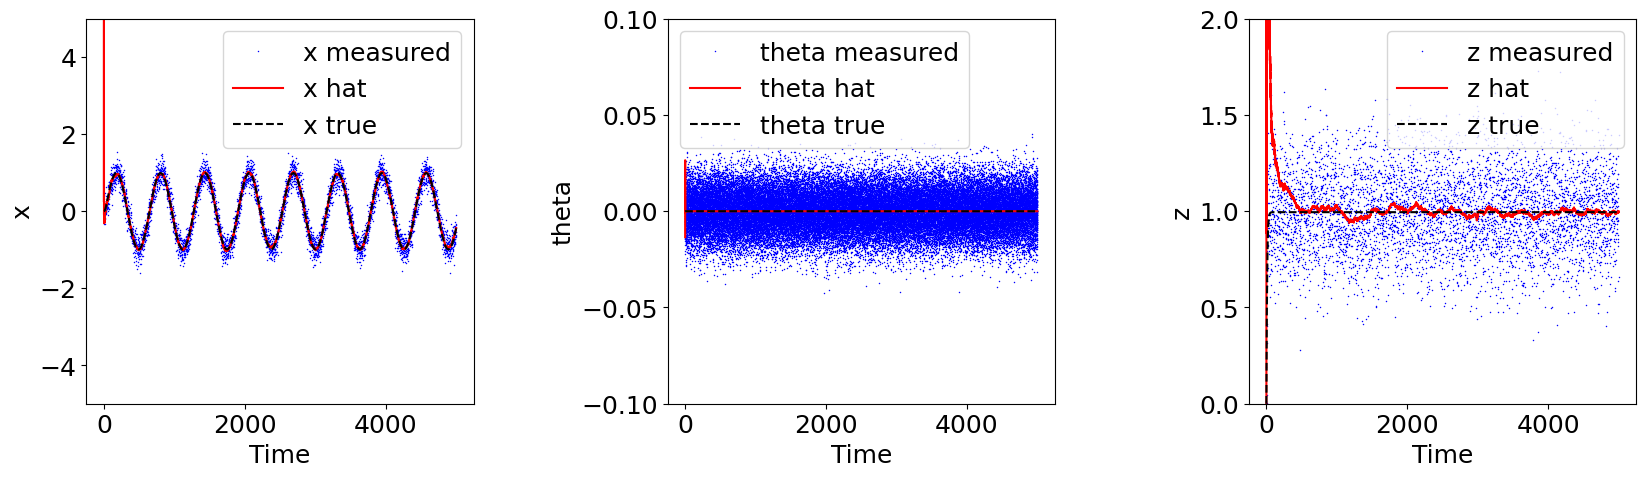

In [34]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x, Y[2,:], x_hat, label_var='x', ax=ax1)
ax1.set_ylim(-5,5)

ax2 = fig.add_subplot(132)
plot_tme(t, theta, Y[0,:], theta_hat, label_var='theta', ax=ax2)
ax2.set_ylim(-.1, 0.1)

ax3 = fig.add_subplot(133)
plot_tme(t, z, Y[3,:], z_hat, label_var='z', ax=ax3)
ax3.set_ylim(0, 2)

In [35]:
theta_dot_hat = xhat_fp[1, :]
x_dot_hat = xhat_fp[3, :]
z_dot_hat = xhat_fp[5, :]

theta_dot = X[1, :]
x_dot = X[3, :]
z_dot = X[5, :]

(-0.05, 0.05)

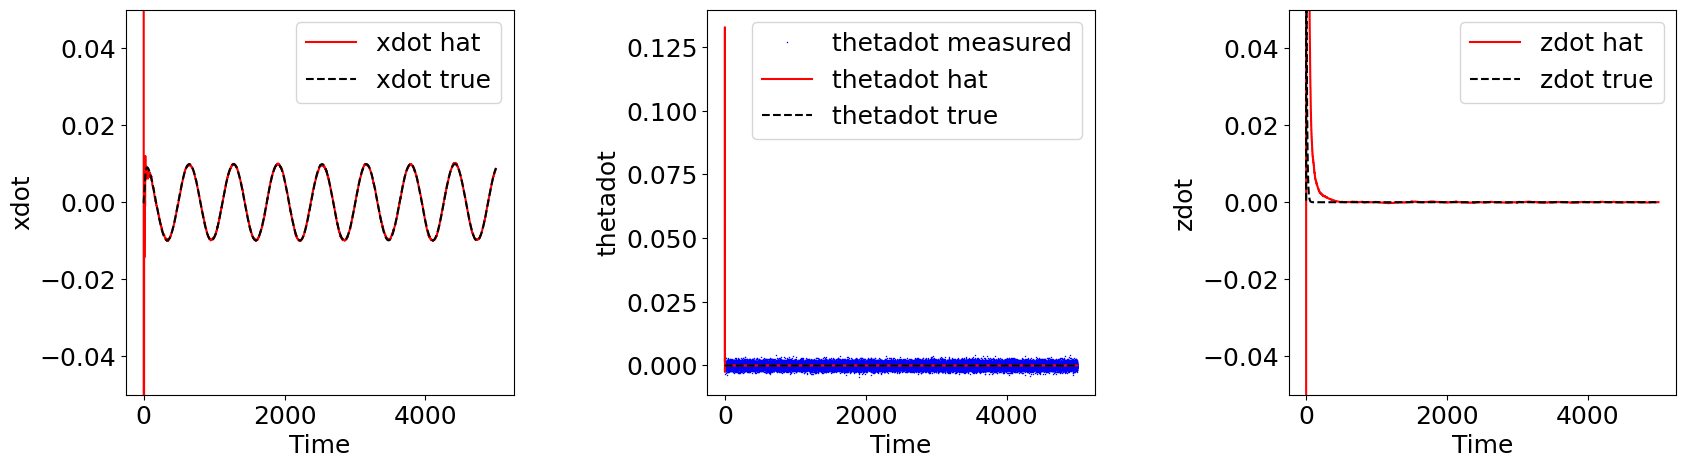

In [36]:
fig = plt.figure(figsize=(20,5))
fig.subplots_adjust(wspace=0.5)


ax1 = fig.add_subplot(131)
plot_tme(t, x_dot, None, x_dot_hat, label_var='xdot', ax=ax1)
ax1.set_ylim(-.05, 0.05)

ax2 = fig.add_subplot(132)
plot_tme(t, theta_dot, Y[1,:], theta_dot_hat, label_var='thetadot', ax=ax2)

ax3 = fig.add_subplot(133)
plot_tme(t, z_dot, None, z_dot_hat, label_var='zdot', ax=ax3)
ax3.set_ylim(-.05, 0.05)